In [1]:
import psfmachine
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord, Angle
from astroquery.gaia import Gaia
import astropy.units as u
import time

%matplotlib widget

In [2]:
def get_gaia_region(ra,dec,size=0.4, magnitude_limit = 15):
    """
    Get the coordinates and mag of all gaia sources in the field of view.
 
    -------
    Inputs-
    -------
    tpf class target pixel file lightkurve class
    magnitude_limit float cutoff for Gaia sources
    Offset int offset for the boundary
 
    --------
    Outputs-
    --------
    coords array coordinates of sources
    Gmag array Gmags of sources
    """
    c1 = SkyCoord(ra, dec, unit='deg')
    Vizier.ROW_LIMIT = -1
 
    result = Vizier.query_region(c1, catalog=["I/345/gaia2"],
                                     radius=Angle(size, "arcmin"),column_filters={'Gmag':f'<{magnitude_limit}'})
 
    # keys = ['objID','RAJ2000','DEJ2000','e_RAJ2000','e_DEJ2000','gmag','e_gmag','gKmag','e_gKmag','rmag',
    #         'e_rmag','rKmag','e_rKmag','imag','e_imag','iKmag','e_iKmag','zmag','e_zmag','zKmag','e_zKmag',
    #         'ymag','e_ymag','yKmag','e_yKmag','tmag','gaiaid','gaiamag','gaiadist','gaiadist_u','gaiadist_l',
    #         'row','col', 'phot_g_mean_mag', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag_error']
 
 
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise no_targets_found_message
 
    print(result)
    result = result['I/345/gaia2'].to_pandas()
    #result = result.rename(columns={'RA_ICRS':'ra','DE_ICRS':'dec'})
    #account for proper motion
    return result

def query_gaia_region(ra, dec, radius_deg, maglim = 17):
    # Define the central coordinates of your region
    # Gaia.MAIN_GAIA_TABLE.set_limit(10000)
    Gaia.ROW_LIMIT = 30000
    coords = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')

    # Define the search radius (half of the square side length)
    radius = radius_deg * u.degree

    # Query Gaia data
    job = Gaia.cone_search_async(coords, radius=radius)
    result = job.get_results().to_pandas()

    result = result[result['phot_g_mean_mag'] < maglim]

    return result


In [3]:
folder = '/Users/zgl12/Research/K2_Files/'
filenames_og = 'k2mosaic-c06-ch61-cad112000_og.fits'
filenames_wcs = 'k2mosaic-c06-ch61-cad112000_wcs.fits'

hdu = fits.open(folder+filenames_og)

header = hdu[0].header
uncert = hdu[2].data
hdu.close()

data, hdr = fits.getdata(folder+filenames_wcs, header=True)

wcs = WCS(hdr)

jd = (header['MJD-BEG'] + header['MJD-END'])/2 + 2400000.5

data_shape = data.shape


Set MJD-END to 57230.009094 from DATE-END'. [astropy.wcs.wcs]
2024-06-18 23:10:15,008 - astroquery - WARNING - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57229.988660 from DATE-OBS.
Set MJD-END to 57230.009094 from DATE-END'.


In [4]:
y_indices, x_indices = np.indices(data_shape)
pixel_coords = np.column_stack([x_indices.flatten(), y_indices.flatten()])
world_coords = wcs.all_pix2world(pixel_coords, 0)

ras = world_coords[:, 0]
decs = world_coords[:, 1]

ras = ras.reshape(data_shape)
decs = decs.reshape(data_shape)

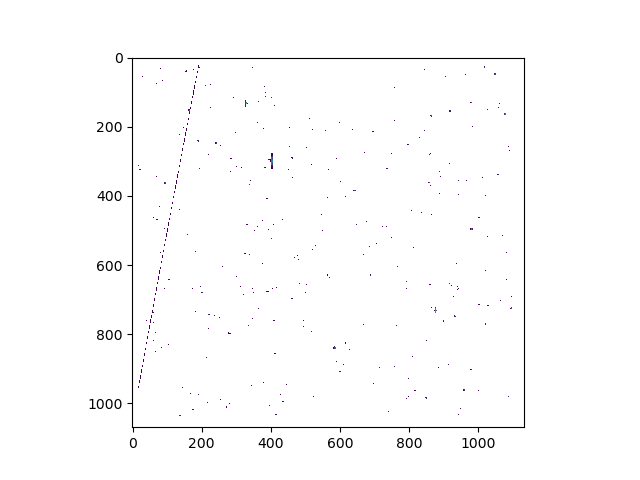

In [5]:
plt.figure()
plt.imshow(data)
plt.show()

In [6]:
ra = 202.9625
dec = -10.736
radius = 5

# coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

# result = Gaia.cone_search_async(coord, radius*u.degree)
# cat = result.get_results().to_pandas()
 
# cat = get_gaia_region([ra],[dec],size=120)
cat = query_gaia_region(ra, dec, 2)

cat = cat[cat['phot_g_mean_mag'] < 17]
# print(len(cat))
 
print(cat.columns)

cat

2024-06-18 23:17:39,979 - astroquery - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Index(['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
3,1635721458409799680,Gaia DR2 3611550145651235200,3611550145651235200,1467934374,2015.5,202.968879,0.044563,-10.759365,0.030434,0.953661,...,200111,0.912232,0.907368,0.919315,0.616361,0.547054,0.685668,https://gea.esac.esa.int/data-server/datalink/...,,0.024189
7,1635721458409799680,Gaia DR2 3611551554400510336,3611551554400510336,221060238,2015.5,202.984435,0.023003,-10.754501,0.015096,0.281971,...,200111,9.744823,9.364520,9.996148,51.683529,40.301620,63.065437,https://gea.esac.esa.int/data-server/datalink/...,,0.028396
25,1635721458409799680,Gaia DR2 3611563855186854528,3611563855186854528,599577381,2015.5,202.946253,0.032636,-10.697012,0.024516,3.732515,...,200111,0.841553,0.790086,0.879584,0.635560,0.626452,0.644668,https://gea.esac.esa.int/data-server/datalink/...,,0.042133
36,1635721458409799680,Gaia DR2 3611550214370710784,3611550214370710784,817583682,2015.5,202.924978,0.040344,-10.765131,0.030560,0.904862,...,200111,0.992109,0.921267,1.061019,0.699708,0.620908,0.778508,https://gea.esac.esa.int/data-server/datalink/...,,0.046991
45,1635721458409799680,Gaia DR2 3611549321017510528,3611549321017510528,366681041,2015.5,202.980403,0.081806,-10.784763,0.056425,0.290069,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.051836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29982,1635721458409799680,Gaia DR2 3617579416445594240,3617579416445594240,1360757614,2015.5,204.172446,0.076885,-10.122761,0.085453,0.395975,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,1.338665
29987,1635721458409799680,Gaia DR2 3610966064458752128,3610966064458752128,773213404,2015.5,202.280145,0.068882,-11.895554,0.051851,0.303315,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,1.338746
29993,1635721458409799680,Gaia DR2 3616801103947880320,3616801103947880320,1548308589,2015.5,204.300362,0.087630,-10.484577,0.093206,4.774348,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,1.338798
29997,1635721458409799680,Gaia DR2 3623863060974586624,3623863060974586624,1013179910,2015.5,201.868031,0.081647,-9.940167,0.059861,0.474712,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,1.338891


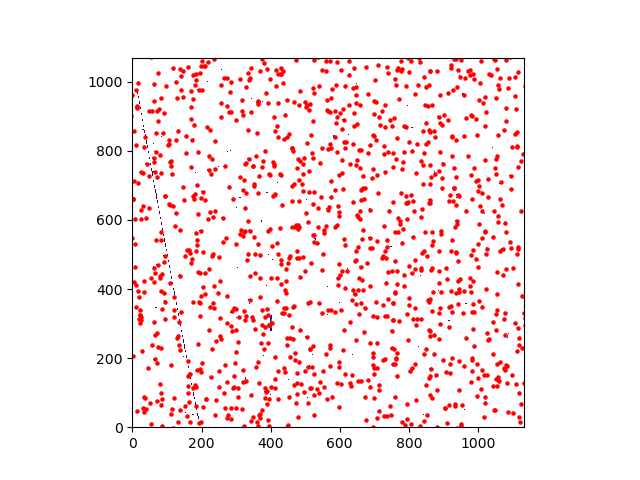

: 

In [7]:
# ra_s = cat['RA_ICRS']
# dec_s = cat['DE_ICRS']
ra_s = cat['ra']
dec_s = cat['dec']

# Stack RA and DEC into a single array
world_coords_s = np.column_stack([ra_s, dec_s])

# Convert world coordinates to pixel coordinates
pixel_coords = wcs.all_world2pix(world_coords_s, 0)

# Extract x and y pixel coordinates
x_pix = pixel_coords[:, 0]
y_pix = pixel_coords[:, 1]

# plt.figure()
# plt.imshow(data)
# plt.scatter(x_pix, y_pix, s=5, c='r')
# plt.xlim(0, data_shape[1])
# plt.ylim(0, data_shape[0])
# plt.show()

In [8]:
# time: numpy.ndarray
#     Time values in JD
# flux: numpy.ndarray
#     Flux values at each pixels and times in units of electrons / sec
# flux_err: numpy.ndarray
#     Flux error values at each pixels and times in units of electrons / sec
# ra: numpy.ndarray
#     Right Ascension coordinate of each pixel
# dec: numpy.ndarray
#     Declination coordinate of each pixel
# sources: pandas.DataFrame
#     DataFrame with source present in the images
# column: np.ndarray
#     Data array containing the "columns" of the detector that each pixel is on.
# row: np.ndarray
#     Data array containing the "rows" of the detector that each pixel is on.

jds = [jd]

# cat['ra'] = cat['RA_ICRS']
# cat['dec'] = cat['DE_ICRS']

machine = psfmachine.Machine(time = jds, flux = data, flux_err = uncert, 
                             ra = ras, dec = decs, sources = cat, 
                             column= x_indices, row = y_indices, sources_flux_column = 'phot_g_mean_flux')